In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin

# Laster inn data

*Skal eigentleg hente inn data med kode inni notebook, men bruker nedlastet filer foreløpigt.*

In [3]:
#kaggle competitions download -c pubg-finish-placement-prediction

Lister filene vi har fått utdelt

In [4]:
print(os.listdir("data"))

['sample_submission_V2.csv', 'test_V2.csv', 'train_V2.csv']


Laster treningsdata og setter det inn i variabel trainData.

In [5]:
trainData = pd.read_csv('data/train_V2.csv')

Finner informasjon om kva data me har med .info()

In [6]:
trainData.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


## Lager valideringssett

In [7]:
lengthSet = trainData.shape[0]
print('Kor mange før split?', lengthSet)
behandletSet, valideringSet = np.split(trainData, [int(lengthSet*0.20)])
print('Like mange etter split?', behandletSet.shape[0] + valideringSet.shape[0] )

Kor mange før split? 4446966
Like mange etter split? 4446966


## Gjøre treningssettet litt mindre for kjappere arbeid

Her tar eg ut ANTALL samples fra treningsettet. Da blir memory-usage mindre og ting går kjappere rundt dataarbeid. Før maskinlæringen må antall bli satt opp igjen til maks.

In [ ]:
ANTALL = 10000
trainData = trainData.sample(ANTALL)
shortTrainData = trainData.copy()
del trainData
gc.collect()
shortTrainData.info()

## Splitte datasettet basert på matchType?

Fyrst tenkte eg at typen match kunne gjøre dataene så forskjellig at det burde bli delt opp i ulike training-set. Dette har eg gått i fra siden fasit(test)-dataene ikkje er mulig å endre på. 

In [ ]:
shortTrainData['matchType'].head()

In [ ]:
trainSolo = shortTrainData.loc[shortTrainData['matchType'] == 'solo'].head()
trainSolo.info()

## Fra objekt til verdi

Bytte ut objekt-verdier til tal.

In [ ]:
encoder = LabelEncoder()
match_types = shortTrainData['matchType']
match_types_encoded = encoder.fit_transform(match_types)
match_types_encoded

In [ ]:
print(encoder.classes_)
encoder.classes_.size

Denne funksjonen tar inn matchtype og kva den sjekker etter og returnerer 1 eller 0. 

In [ ]:
def team_mode(matchType, isWhat):
    if matchType in ['normal-solo', 'normal-solo-fpp', 'solo', 'solo-fpp'] and isWhat == 'isSolo':
        return 1
    elif matchType in ['duo', 'duo-fpp', 'normal-duo', 'normal-duo-fpp'] and isWhat == 'isDuo':
        return 1
    elif matchType in ['normal-squad', 'normal-squad-fpp', 'squad', 'squad-fpp'] and isWhat == 'isSquad':
        return 1
    else:
        return 0

In [ ]:
print(team_mode('normal-duo-fpp', 'isDuo'))

Setter inn tre nye attributter.

In [ ]:
shortTrainData['isSolo'] = shortTrainData.apply(lambda x:team_mode(x['matchType'],'isSolo'), axis=1)
shortTrainData['isDuo'] = shortTrainData.apply(lambda x:team_mode(x['matchType'],'isDuo'), axis=1)
shortTrainData['isSquad'] = shortTrainData.apply(lambda x:team_mode(x['matchType'],'isSquad'), axis=1)

In [ ]:
shortTrainData.head(5)

Gjør faktisk matchType om til talverdiene. Usikker på om eg vil dette.

In [ ]:
#shortTrainData['matchType'] = match_types_encoded;
#shortTrainData['matchType'].head(5)

In [ ]:
shortTrainData = shortTrainData.drop('matchType', axis=1)

For at verdien nerme kvarandre ikkje skal bli vurdert like, lager vi nye attributter for kvar verdi med OneHotEncoder.

In [ ]:
encoder = OneHotEncoder()
match_types_1hot = encoder.fit_transform(match_types_encoded.reshape(-1, 1))
match_types_1hot

## Endre datatyper

Noken typer er unødvendig satt. For å gjøre settet mindre kan eg endre til mindre typer.

In [18]:
dtypes = {
        'assists'           : 'uint8',
        'boosts'            : 'uint8',
        'damageDealt'       : 'float16',
        'DBNOs'             : 'uint8',
        'headshotKills'     : 'uint8', 
        'heals'             : 'uint8',    
        'killPlace'         : 'uint8',    
        'killPoints'        : 'uint16',    
        'kills'             : 'uint8',    
        'killStreaks'       : 'uint8',    
        'longestKill'       : 'float16',    
        'maxPlace'          : 'uint8',    
        'numGroups'         : 'uint8',    
        'revives'           : 'uint8',    
        'rideDistance'      : 'float16',    
        'roadKills'         : 'uint8',    
        'swimDistance'      : 'float16',    
        'teamKills'         : 'uint8',    
        'vehicleDestroys'   : 'uint8',    
        'walkDistance'      : 'float16',    
        'weaponsAcquired'   : 'uint8',    
        'winPoints'         : 'uint8', 
        'winPlacePerc'      : 'float16' 
}

In [19]:
shortTrainData = shortTrainData.astype(dtypes)

Fjerner Id, groupId og matchId. Tenker de ikkje har påvirkning på winPlacePerc.

In [ ]:
shortTrainData = shortTrainData.drop(["Id", "groupId", "matchId"], axis=1)
shortTrainData.info()

Ser over at memory-usage er betraktelig mindre enn etter import.

# Korrelasjon

Målet er å finne ut kva plass mellom 0 og 1 (prosent) kvar spelar kjem på. Da kan det vere fint å sjå korrelasjon mellom vinnar og resten av atributtene:

In [ ]:
corr_matrix = shortTrainData.corr();
corr_matrix["winPlacePerc"].sort_values(ascending=False)

Lengde gått var mest i korrelasjon, printer ut ein graf:

In [ ]:
attributes = ["winPlacePerc", "walkDistance"] #, "killPlace", "boosts", "weaponsAcquired"
scatter_matrix(shortTrainData[attributes], figsize=(12, 8), color="blue", alpha=0.1)

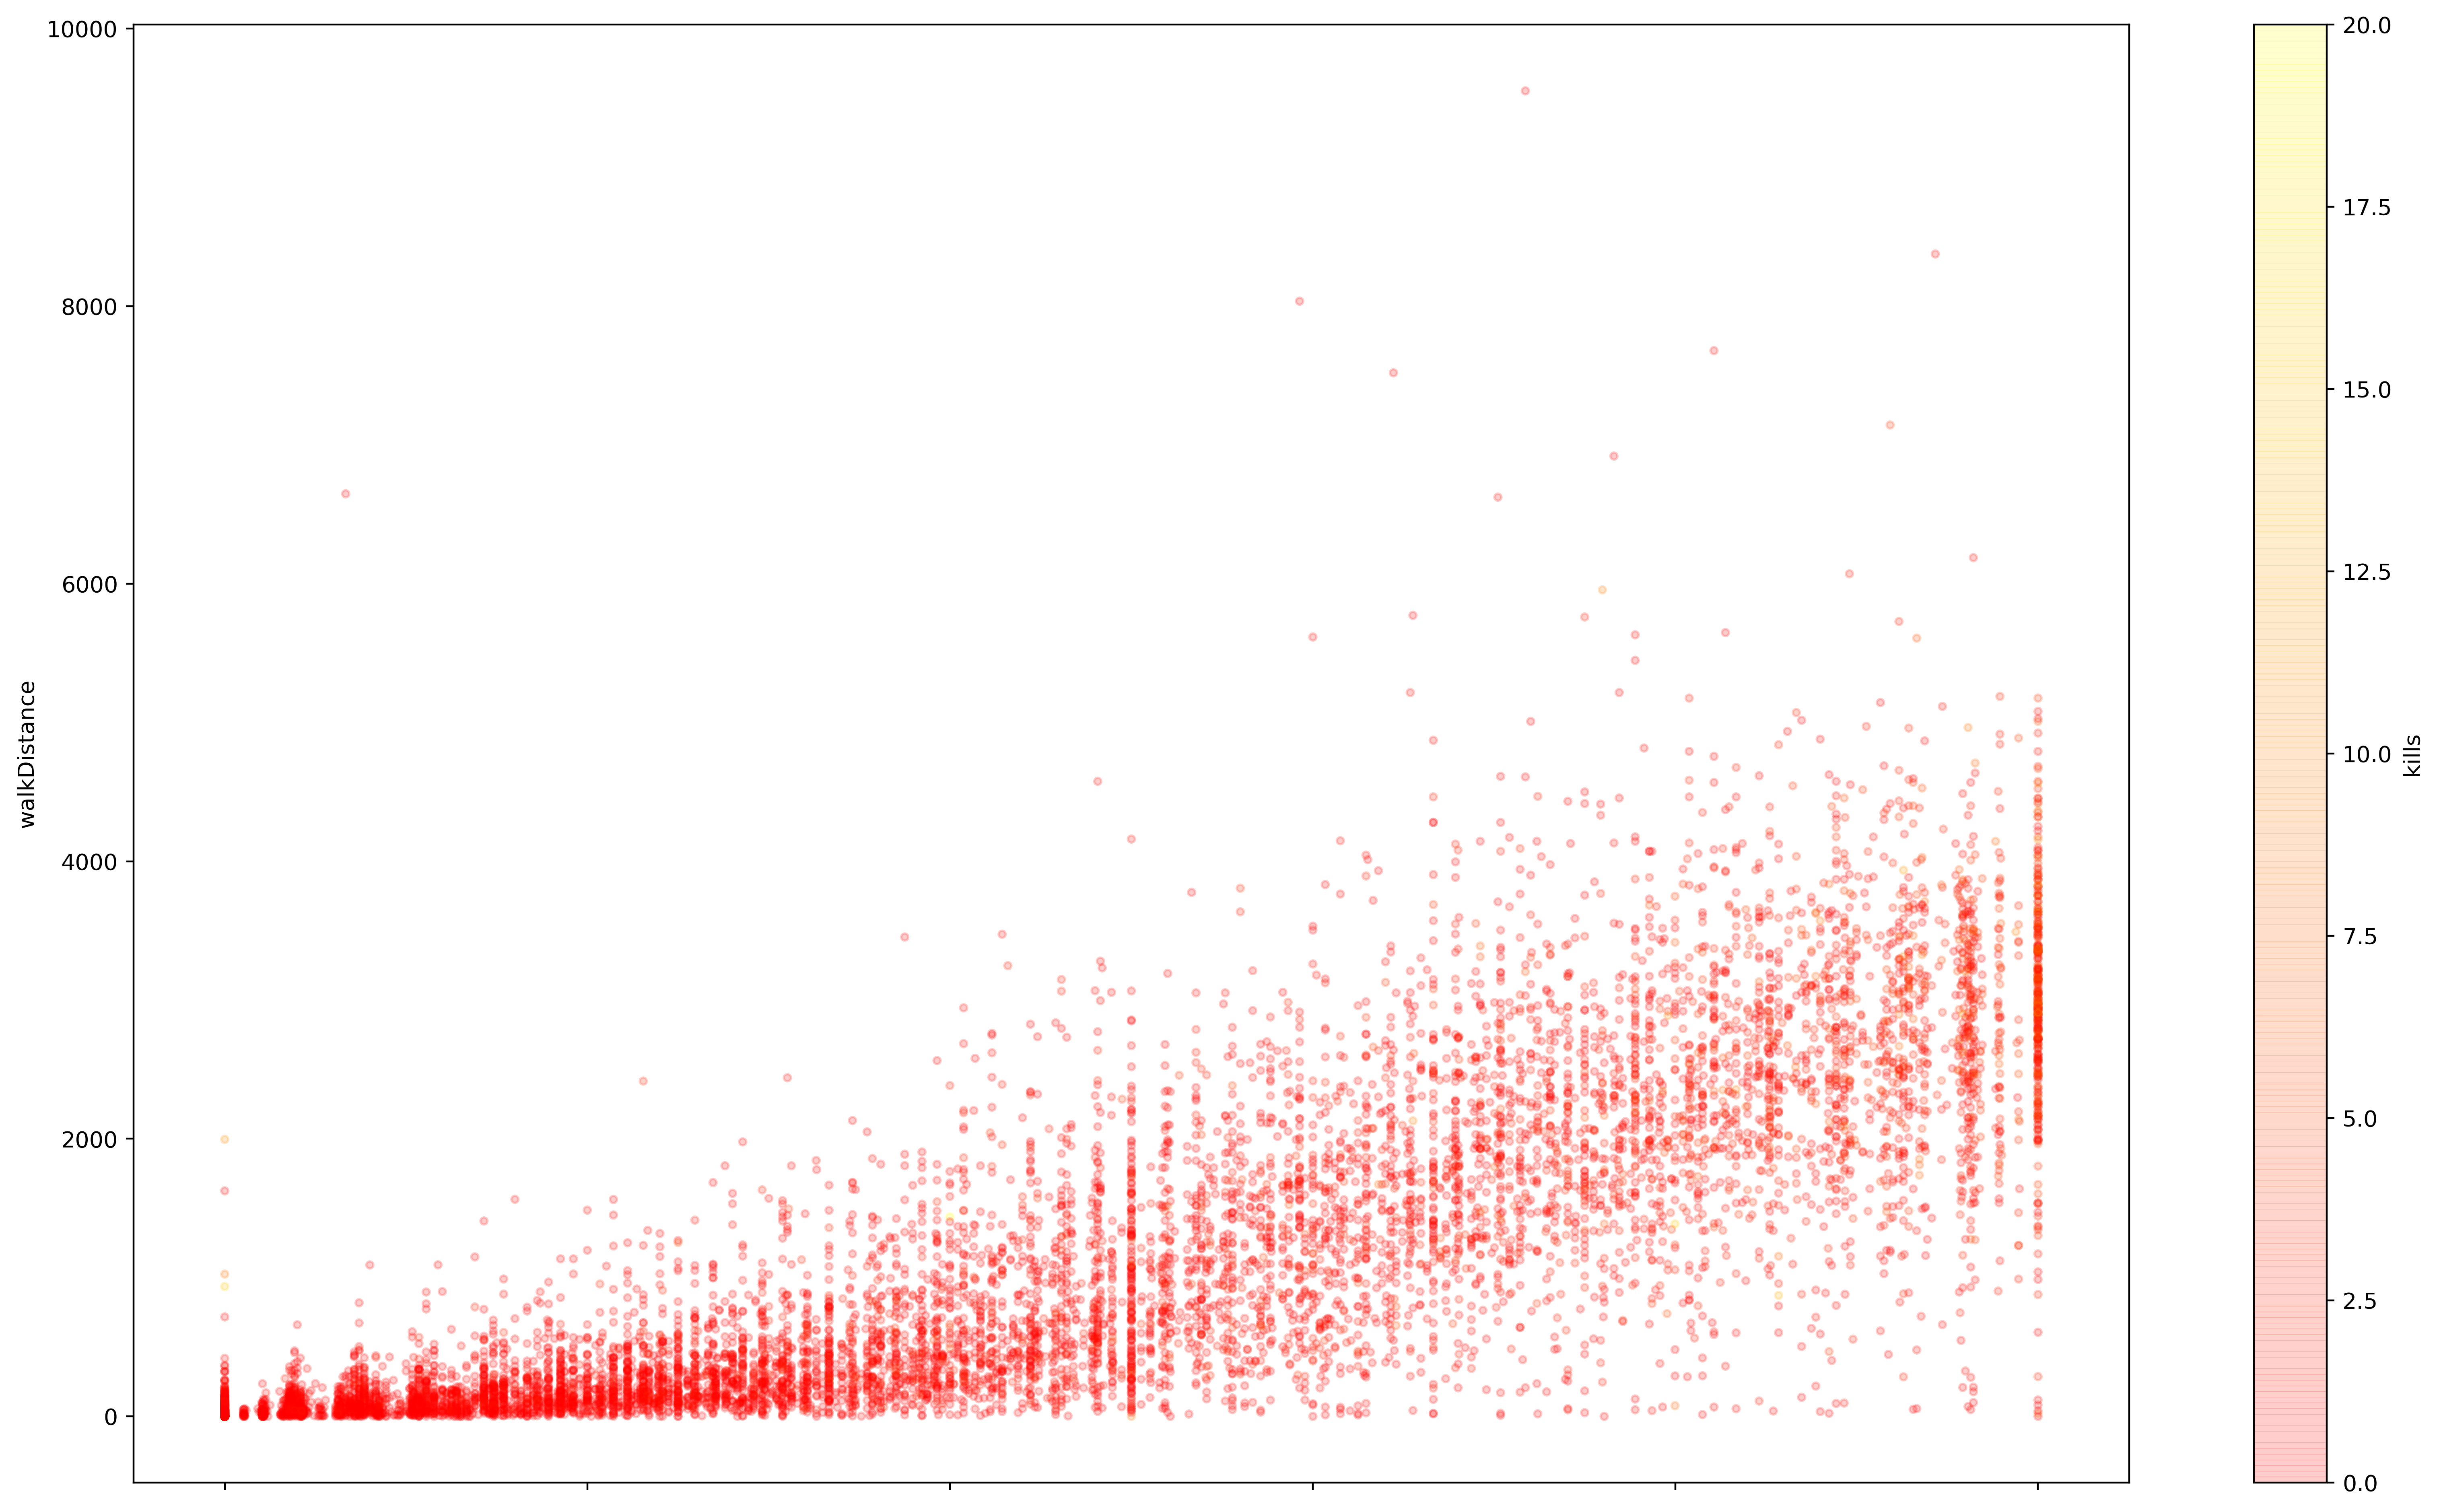

In [24]:
plt.rcParams['figure.figsize'] = (20,12)
plt.rcParams['figure.dpi'] = 400
shortTrainData.plot.scatter( 
                    x='winPlacePerc', 
                    y='walkDistance', 
                    c='kills',
                    colormap='autumn',
                    s=10,
                    alpha=0.2
)


In [25]:
pd.set_option('display.max_columns', 999)
#trainData.sort_values(by=['kills'], ascending=False)

Liten oversikt over kva kvar verdi betyr i datasettet, definert i Kaggle
* groupId - Integer ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
* matchId - Integer ID to identify match. There are no matches that are in both the training and testing set.
* assists - Number of enemy players this player damaged that were killed by teammates.
* boosts - Number of boost items used.
* damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
* DBNOs - Number of enemy players knocked.
* headshotKills - Number of enemy players killed with headshots.
* heals - Number of healing items used.
* killPlace - Ranking in match of number of enemy players killed.
* killPoints - Kills-based external ranking of player. (Think of this as an * Elo ranking where only kills matter.)
* kills - Number of enemy players killed.
* killStreaks - Max number of enemy players killed in a short amount of time.
* longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a - player and driving away may lead to a large longestKill stat.
* maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
* numGroups - Number of groups we have data for in the match.
* revives - Number of times this player revived teammates.
* rideDistance - Total distance traveled in vehicles measured in meters.
* roadKills - Number of kills while in a vehicle.
* swimDistance - Total distance traveled by swimming measured in meters.
* teamKills - Number of times this player killed a teammate.
* vehicleDestroys - Number of vehicles destroyed.
* walkDistance - Total distance traveled on foot measured in meters.
* weaponsAcquired - Number of weapons picked up.
* winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.)
* winPlacePerc - The target of prediction. This is a percentile winning * placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

# Ny aktuelle attributter

### Headshot-percentage

headshotKills/kills definerer prosent hodekills og kan kanskje korrelere til ferdigheiter.

In [ ]:
shortTrainData["headshotPercentage"] = (shortTrainData['headshotKills'])/(shortTrainData['kills'])
shortTrainData["headshotPercentage"] = shortTrainData["headshotPercentage"].fillna(0.00)

Sjekker ny korrelasjon

In [ ]:
corr_matrix = shortTrainData.corr();
corr_matrix["winPlacePerc"].sort_values(ascending=False)

Korrelasjon var veldig veldig lite. Kommer av at man kan få høg % med kunn eitt kill. Ikkje viktig likevel.

### Total distance traveled

Lager ein ny attribut med navn totalTraversed som er sum av 'rideDistance', 'swimDistance' og 'walkDistance'.

In [ ]:
shortTrainData['totalTraversed'] = shortTrainData['rideDistance'] + shortTrainData['swimDistance'] + shortTrainData['walkDistance']
shortTrainData['totalTraversed'].sample(3)

In [29]:
corr_matrix = shortTrainData.corr();
corr_matrix["winPlacePerc"].sort_values(ascending=False)

winPlacePerc          1.000000
walkDistance          0.815869
totalTraversed        0.680881
boosts                0.641502
weaponsAcquired       0.559849
damageDealt           0.453298
kills                 0.429039
heals                 0.423418
longestKill           0.423295
killStreaks           0.389617
rideDistance          0.340809
headshotKills         0.295013
DBNOs                 0.290483
assists               0.283544
revives               0.253778
swimDistance          0.149895
vehicleDestroys       0.077859
numGroups             0.045390
maxPlace              0.044010
isSolo                0.030298
isDuo                 0.027715
headshotPercentage    0.024716
roadKills             0.023044
rankPoints            0.020179
killPoints            0.010108
teamKills             0.006990
matchDuration        -0.000600
winPoints            -0.046721
isSquad              -0.047598
killPlace            -0.727281
Name: winPlacePerc, dtype: float64

Ganske bra, men mindre enn walkDistance.

### Total traversed tid over match duration

Total traversert delt på tid matchen varte? Dei som lever lengre har gått lengre?

In [ ]:
shortTrainData['walk-time'] = shortTrainData['totalTraversed']/shortTrainData['matchDuration']
corr_matrix = shortTrainData.corr();
corr_matrix["winPlacePerc"].sort_values(ascending=False)

# Bruke transformers og pipelines istedenfor

For at me skal kunne teste modellen må test/valideringsdata ha den samme bahandling som trainingdata. Da kan eg lage ein full_pipeline som gjør all behandling likt på begge datasettene. 

Lager transformer som skal gjøre det mulig å lage ein pipeline

In [8]:
typer = {
        'assists'           : 'uint8',
        'boosts'            : 'uint8',
        'damageDealt'       : 'float16',
        'DBNOs'             : 'uint8',
        'headshotKills'     : 'uint8', 
        'heals'             : 'uint8',    
        'killPlace'         : 'uint8',    
        'killPoints'        : 'uint16',    
        'kills'             : 'uint8',    
        'killStreaks'       : 'uint8',    
        'longestKill'       : 'float16',    
        'maxPlace'          : 'uint8',    
        'numGroups'         : 'uint8',    
        'revives'           : 'uint8',    
        'rideDistance'      : 'float16',    
        'roadKills'         : 'uint8',    
        'swimDistance'      : 'float16',    
        'teamKills'         : 'uint8',    
        'vehicleDestroys'   : 'uint8',    
        'walkDistance'      : 'float16',    
        'weaponsAcquired'   : 'uint8',    
        'winPoints'         : 'uint8', 
        'winPlacePerc'      : 'float16' 
}

In [9]:
class SetDtypes(BaseEstimator, TransformerMixin):
    def __init__(self, dtypes):
        self.dtypes = dtypes
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.astype(dtypes)

In [10]:
class addAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, shouldUseNewAttribs = True):
        self.shouldUseNewAttribs = shouldUseNewAttribs
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        headshotPercentage = X['headshotKills']/X['kills']
        headshotPercentage.fillna(0.00)
        totalTraversed = X['rideDistance'] + X['swimDistance'] + X['walkDistance']
        walktime = X['totalTraversed']/X['matchDuration']
        if self.shouldUseNewAttribs:
            return np.c_[X, headshotPercentage, totalTraversed, walktime]
        else:
            return np.c_[X]

In [11]:
class DataFrameRemover(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names = ["Id", "groupId", "matchId"]):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(attribute_names, axis=1)

In [12]:
class MatchTypeEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, noNeed = True):
        self.noNeed = noNeed
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        isSolo = X.apply(lambda x:team_mode(x['matchType'],'isSolo'), axis=1)
        isDuo = X.apply(lambda x:team_mode(x['matchType'],'isDuo'), axis=1)
        isSquad = X.shortTrainData.apply(lambda x:team_mode(x['matchType'],'isSquad'), axis=1)
        return np_c[X, isSolo, isDuo, isSquad].drop('matchType', axis=1)

Pipeline som gjør data klare.

In [13]:
full_pipeline = Pipeline([
    ('editTypes', SetDtypes(typer)), 
    ('addAttribs', addAttributes()),
    ('removeAttribs', DataFrameRemover()),
    ('matchType_encoder', MatchTypeEncoder()),
])

### Skille labels frå treningsdata

In [14]:
PUBG_label = behandletSet['winPlacePerc'].copy()
behandletSet = behandletSet.drop('winPlacePerc', axis=1)

In [15]:
print(PUBG_label)
print(behandletSet.info())

0         0.4444
1         0.6400
2         0.7755
3         0.1667
4         0.1875
           ...  
889388    0.5745
889389    0.0000
889390    0.1364
889391    0.5556
889392    0.7158
Name: winPlacePerc, Length: 889393, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889393 entries, 0 to 889392
Data columns (total 28 columns):
Id                 889393 non-null object
groupId            889393 non-null object
matchId            889393 non-null object
assists            889393 non-null int64
boosts             889393 non-null int64
damageDealt        889393 non-null float64
DBNOs              889393 non-null int64
headshotKills      889393 non-null int64
heals              889393 non-null int64
killPlace          889393 non-null int64
killPoints         889393 non-null int64
kills              889393 non-null int64
killStreaks        889393 non-null int64
longestKill        889393 non-null float64
matchDuration      889393 non-null int64
matchType          889393 non

Bruke pipeline på datasettene

In [16]:
behandletSet = full_pipeline.fit(behandletSet, PUBG_label)
valideringSet = full_pipeline.fit(valideringSet)

NameError: name 'dtypes' is not defined

In [ ]:
print(behandletSet.info())
print(valideringSet.info())

# Linear Regression

In [42]:
shortTrainData.isnull().sum()

assists               0
boosts                0
damageDealt           0
DBNOs                 0
headshotKills         0
heals                 0
killPlace             0
killPoints            0
kills                 0
killStreaks           0
longestKill           0
matchDuration         0
maxPlace              0
numGroups             0
rankPoints            0
revives               0
rideDistance          0
roadKills             0
swimDistance          0
teamKills             0
vehicleDestroys       0
walkDistance          0
weaponsAcquired       0
winPoints             0
isSolo                0
isDuo                 0
isSquad               0
headshotPercentage    0
totalTraversed        0
walk-time             0
dtype: int64

In [41]:
lin_reg = LinearRegression()
lin_reg.fit(shortTrainData, PUBG_label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [45]:
?RandomForestRegressor

In [ ]:
param_grid_large = {
    'bootstrap': [True, False],
    'n_estimators': [10, 100, 150, 200, 300],
    #max_depth
    #min_sample_leaf
}


grid search afterward...